# Attention with curriculum learning

The point of this notebook is to use curriculum learning

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
from pathlib import Path
from collections import Counter

import sys
sys.path.append('/Users/psavala/Local_DS/Addition-RNN/Code')

In [2]:
from models.seq2seq import Seq2Seq
from utils.integers import char_to_int_map, input_seq_length, target_seq_length
from utils.common import reverse_dict
from utils.data import Data
from utils.file_io import list_to_csv
from utils.training import format_targets
from utils.prediction import pprint_metrics
from data_gen.integer_addition import generate_samples


from tensorflow.keras.optimizers import Adam

In [41]:
class Config:
    n_terms = 3
    n_digits = 2
    train_size = 5 * 10**3
    test_size = 10**3
    validation_split = 0
    epochs = 100
    reverse = False
    encoder_units = 32
    batch_size = 64
    allow_less_terms = False
    uniform_samples = False
    generalize_to_n_terms = False
    saved_data = Data.uniform_sum
    
data_type = 'random'


class Mappings:
    char_to_int = char_to_int_map()
    int_to_char = reverse_dict(char_to_int)

## Load integer addition data

In [9]:
def save(a, fname, data_type, n_terms, n_digits):
    term_dig_dir = Path(f'{n_terms}term_{n_digits}digs')

    file_dir = Path('../Code') / Path('data') / Path(data_type) / term_dig_dir
    np.save(file_dir / Path(fname), a, allow_pickle=True)

In [10]:
def load_full(data_type, n_terms, n_digits):
    term_dig_dir = Path(f'{n_terms}term_{n_digits}digs')

    file_dir = Path('../Code') / Path('data') / Path(data_type) / term_dig_dir
    X_train = np.load(file_dir / Path('X_train.npy'), allow_pickle=True)
    X_test = np.load(file_dir / Path('X_test.npy'), allow_pickle=True)
    y_train = np.load(file_dir / Path('y_train.npy'), allow_pickle=True)
    y_test = np.load(file_dir / Path('y_test.npy'), allow_pickle=True)

    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = load_full(data_type, Config.n_terms, Config.n_digits)

In [12]:
X_train.shape

(700000, 9)

In [13]:
X_train[0]

array([ 7, 10,  1,  2, 10,  9,  1, 12, 13])

In [14]:
y_train.shape

(700000, 5)

In [15]:
y_train[0]

array([11,  1,  1,  0, 12])

In [16]:
X_train.shape, y_train.shape

((700000, 9), (700000, 5))

In [17]:
X_test.shape, y_test.shape

((300000, 9), (300000, 5))

In [18]:
def decode(v):
    return Mappings.int_to_char[v]

## Split into curriculum sets (SKIP)

Split into sums with only one non-zero summands, two non-zero summands, and remaining sums.

In [84]:
one_nonzero_X = []
one_nonzero_y = []

two_nonzero_X = []
two_nonzero_y = []

three_nonzero_X = []
three_nonzero_y = []

c = 0
for x, y in zip(X_train, y_train):
    x_dec = ''.join(decode(n) for n in x)
    x_dec = x_dec.replace('\n', '').replace(' ', '')
    # One non-zero summand
    if x_dec.startswith('0+0+') or x_dec.endswith('+0+0') or (x_dec.startswith('0+') and x_dec.endswith('+0')):
        one_nonzero_X.append(x)
        one_nonzero_y.append(y)
    elif x_dec.startswith('0+') or x_dec.endswith('+0') or ('+0+' in x_dec):
        two_nonzero_X.append(x)
        two_nonzero_y.append(y)
    else:
        three_nonzero_X.append(x)
        three_nonzero_y.append(y)
        
one_nonzero_X = np.array(one_nonzero_X)
one_nonzero_y = np.array(one_nonzero_y)

two_nonzero_X = np.array(two_nonzero_X)
two_nonzero_y = np.array(two_nonzero_y)

three_nonzero_X = np.array(three_nonzero_X)
three_nonzero_y = np.array(three_nonzero_y)

In [85]:
save(one_nonzero_X, 'X_train_one_nonzero.npy', 'random', 3, 2)
save(one_nonzero_y, 'y_train_one_nonzero.npy', 'random', 3, 2)

save(two_nonzero_X, 'X_train_two_nonzero.npy', 'random', 3, 2)
save(two_nonzero_y, 'y_train_two_nonzero.npy', 'random', 3, 2)

save(three_nonzero_X, 'X_train_three_nonzero.npy', 'random', 3, 2)
save(three_nonzero_y, 'y_train_three_nonzero.npy', 'random', 3, 2)

## Load curriculum datasets

In [7]:
term_dig_dir = Path(f'{Config.n_terms}term_{Config.n_digits}digs')
file_dir = Path('../Code') / Path('data') / Path(data_type) / term_dig_dir

one_nonzero_X = np.load(file_dir / Path('X_train_one_nonzero.npy'), allow_pickle=True)
one_nonzero_y = np.load(file_dir / Path('y_train_one_nonzero.npy'), allow_pickle=True)

two_nonzero_X = np.load(file_dir / Path('X_train_two_nonzero.npy'), allow_pickle=True)
two_nonzero_y = np.load(file_dir / Path('y_train_two_nonzero.npy'), allow_pickle=True)

three_nonzero_X = np.load(file_dir / Path('X_train_three_nonzero.npy'), allow_pickle=True)
three_nonzero_y = np.load(file_dir / Path('y_train_three_nonzero.npy'), allow_pickle=True)

### Create a tf.data dataset

In [19]:
BUFFER_SIZE = X_train.shape[0]
BATCH_SIZE = 32
steps_per_epoch = X_train.shape[0] // BATCH_SIZE
embedding_dim = 13
units = 256
bidir = True
vocab_inp_size = len(Mappings.char_to_int)
vocab_tar_size = len(Mappings.char_to_int)

# Data is already padded, so we can just grab any one
max_length_inp = len(X_train[0])
max_length_targ = len(y_train[0])

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

train_one_nonzero_ds = tf.data.Dataset.from_tensor_slices((one_nonzero_X, one_nonzero_y)).shuffle(BUFFER_SIZE)
train_one_nonzero_ds = train_one_nonzero_ds.batch(BATCH_SIZE, drop_remainder=True)

train_two_nonzero_ds = tf.data.Dataset.from_tensor_slices((two_nonzero_X, two_nonzero_y)).shuffle(BUFFER_SIZE)
train_two_nonzero_ds = train_two_nonzero_ds.batch(BATCH_SIZE, drop_remainder=True)

train_three_nonzero_ds = tf.data.Dataset.from_tensor_slices((three_nonzero_X, three_nonzero_y)).shuffle(BUFFER_SIZE)
train_three_nonzero_ds = train_three_nonzero_ds.batch(BATCH_SIZE, drop_remainder=True)

Sanity checks

In [20]:
example_input_batch, example_target_batch = next(iter(train_ds))
example_input1_batch, example_target1_batch = next(iter(train_one_nonzero_ds))
example_input2_batch, example_target2_batch = next(iter(train_two_nonzero_ds))
example_input3_batch, example_target3_batch = next(iter(train_three_nonzero_ds))

assert example_input_batch.shape == example_input1_batch.shape == example_input2_batch.shape == example_input3_batch.shape
assert example_target_batch.shape == example_target1_batch.shape == example_target2_batch.shape == example_target3_batch.shape

## Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [21]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, bidir):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.bidir = bidir
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, name='Encoder_Embedding')
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform',
                                       name='Encoder_GRU')
        if bidir:
            self.bidir_gru = tf.keras.layers.Bidirectional(self.gru, name='Encoder_BidirGRU')

    def call(self, x, hidden):
        x = self.embedding(x)
        if not self.bidir:
            output, state = self.gru(x, initial_state = hidden)
        else:
            hidden = [hidden, hidden]
            output, forward_state, reverse_state = self.bidir_gru(x, initial_state = hidden)
            state = tf.concat([forward_state, reverse_state], axis=1)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [22]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, bidir)

In [23]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units, bidir):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units, name='Attn_W1')
        self.W2 = tf.keras.layers.Dense(units, name='Attn_W2')
        self.V = tf.keras.layers.Dense(1, name='Attn_V')
        self.bidir = bidir

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [24]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, bidir):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.bidir = bidir
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, name='Decoder_Embedding')
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform',
                                       name='Decoder_GRU')
        if bidir:
            self.bidir_gru = tf.keras.layers.Bidirectional(self.gru, name='Decoder_BidirGRU')
        self.fc = tf.keras.layers.Dense(vocab_size, name='Decoder_FC')

        # used for attention
        self.attention = BahdanauAttention(self.dec_units, self.bidir)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        if not self.bidir:
            output, state = self.gru(x)
        else:
            output, forward_state, reverse_state = self.bidir_gru(x)
            state = tf.concat([forward_state, reverse_state], axis=1)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [25]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, bidir)

## Define the optimizer and the loss function

In [26]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    # Mask whitespace first
    mask = tf.math.logical_not(tf.math.equal(real, Mappings.char_to_int[' ']))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [45]:
checkpoint_dir = './training_checkpoints_curriculum'
if Config.reverse:
    checkpoint_dir += '_reverse'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Curriculum training
- Start with the one_nonzero training set and go through the following steps.
- Repeat for two_nonzero training set
- Repeat for three_nonzero training set

### General training steps
1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [39]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        # print(f'enc_output.shape = {enc_output.shape}')
        # print(f'enc_hidden.shape = {enc_hidden.shape}')

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([Mappings.char_to_int['\t']] * BATCH_SIZE, 1)
        dec_input = tf.dtypes.cast(dec_input, tf.float32)
        # print(f'dec_input.shape = {dec_input.shape}')

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            # print(f'predictions.shape = {predictions.shape}')
            # print(f'dec_hidden.shape = {dec_hidden.shape}')

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [40]:
EPOCHS = 10

curr_ds = [train_one_nonzero_ds, train_two_nonzero_ds, train_three_nonzero_ds]

print(f'Begin curriculum training')
if Config.reverse:
    print('Reversed y in training set')

# Initial values
enc_hidden = encoder.initialize_hidden_state()
total_loss = 0

for i, ds in enumerate(curr_ds):
    print(f'Training with {i+1} nonzero terms\n')
    for epoch in range(EPOCHS):
        start = time.time()

        for (batch, (inp, targ)) in enumerate(ds.take(steps_per_epoch)):
            if Config.reverse:
                targ = np.flip(targ)
            batch_loss = train_step(inp, targ, enc_hidden)
            total_loss += batch_loss

        # saving (checkpoint) the model every 2 epochs
        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    print('='*40)

Begin curriculum training
Reversed y in training set
Training with 1 nonzero terms

Epoch 1 Loss 0.0057
Time taken for 1 epoch 5.7587690353393555 sec

Epoch 2 Loss 0.0082
Time taken for 1 epoch 0.36271095275878906 sec

Epoch 3 Loss 0.0094
Time taken for 1 epoch 0.28145813941955566 sec

Epoch 4 Loss 0.0101
Time taken for 1 epoch 0.35988616943359375 sec

Epoch 5 Loss 0.0106
Time taken for 1 epoch 0.2576899528503418 sec

Epoch 6 Loss 0.0110
Time taken for 1 epoch 0.3625829219818115 sec

Epoch 7 Loss 0.0114
Time taken for 1 epoch 0.2603609561920166 sec

Epoch 8 Loss 0.0117
Time taken for 1 epoch 0.35771989822387695 sec

Epoch 9 Loss 0.0120
Time taken for 1 epoch 0.25440120697021484 sec

Epoch 10 Loss 0.0123
Time taken for 1 epoch 0.3604869842529297 sec

Training with 2 nonzero terms

Epoch 1 Loss 0.0565
Time taken for 1 epoch 26.791308879852295 sec

Epoch 2 Loss 0.0890
Time taken for 1 epoch 48.84381699562073 sec

Epoch 3 Loss 0.1204
Time taken for 1 epoch 44.75803804397583 sec

Epoch 4 Lo

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [42]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    # Preprocess the input
    if isinstance(sentence, str):
        inputs = [Mappings.char_to_int[i] for i in sentence]
    else:
        inputs = sentence
    inputs = np.array(inputs).reshape(1, -1)
    inputs = tf.convert_to_tensor(inputs)

    # Start with a blank result
    result = ''

    # Initial hidden state is zeros
    hidden = tf.zeros((1, units))

    # Encode the input
    enc_out, enc_hidden = encoder(inputs, hidden)

    # Use the encoder's final hidden state as the dec's initial hidden state
    dec_hidden = enc_hidden
  
    # Start by feeding the decoder the starting character 
    dec_input = tf.expand_dims([Mappings.char_to_int['\t']], 0)

    for t in range(max_length_targ):
        # Continually decode the current result, and store the attention weights for plotting
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += Mappings.int_to_char[predicted_id]

        if predicted_id == Mappings.char_to_int['\n']:
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [43]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='Reds')

    fontdict = {'fontsize': 14}
    sentence = list(sentence)
    # Appending a \n doesn't jive with padding, need to fix this
    sentence[-1] = r'\n'
    predicted_sentence = list(predicted_sentence)
    predicted_sentence[-1] = r'\n'

    xticks = [''] + sentence
    yticks = [''] + predicted_sentence
    ax.set_xticklabels(xticks, fontdict=fontdict)
    ax.set_yticklabels(yticks, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [44]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    # attention_plot = attention_plot[:len(result), :len(sentence)]
    plot_attention(attention_plot, sentence, result)

## Restore the latest checkpoint and test

In [55]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [33]:
def generate_example_plot(input=None, idx=None):
    output = None
    if idx is None and input is None:
        idx = np.random.randint(X_test.shape[1])
    if input is None:
        input = X_test[idx]
        output = y_test[idx]
    if not isinstance(input, str):
        test_input = ''.join([decode(x) for x in input])
    else:
        test_input = input
    translate(test_input)

    if output is not None:
        print(f'Actual: {"".join([decode(x) for x in output]).strip()}')

Input: 70+0+0
  
Predicted translation: 71



<ipython-input-30-c1de69a79c6e>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, fontdict=fontdict)
<ipython-input-30-c1de69a79c6e>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks, fontdict=fontdict)


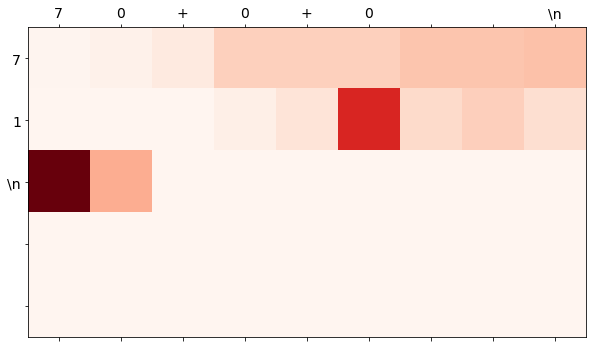

In [34]:
generate_example_plot(one_nonzero_X[0])

## Plot on all sums

Generate predictions for all possible sums and save the results.

In [56]:
X_all = np.vstack([X_train, X_test])
y_all = np.vstack([y_train, y_test])

In [57]:
X_all.shape, y_all.shape

((1000000, 9), (1000000, 5))

In [59]:
preds_fname = f'basic_addition_{Config.n_terms}term_{Config.n_digits}dig_{Config.encoder_units}units_curriculum'
if Config.reverse:
    preds_fname += '_reverse'

correct_buffer = []
incorrect_buffer = []

for i in range(X_all.shape[0]):
    if i > 0 and i % int(0.1 * X_all.shape[0]) == 0:
        print(f'{i}/{X_all.shape[0]}')
        print(f'{100*len(correct_buffer)/i:.1f}% correct')
        print('-'*20)
        list_to_csv(correct_buffer, preds_fname + '_correct.csv', headers='X_true, y_true')
        list_to_csv(incorrect_buffer, preds_fname + '_incorrect.csv', headers='X_true, y_pred, y_true')
        correct_buffer = []
        incorrect_buffer = []
    pred, _, _ = evaluate(X_all[i])
    if Config.reverse:
        y_true = ''.join(decode(n) for n in np.flip(y_all[i]))
    else:
        y_true = ''.join(decode(n) for n in y_all[i])
    y_true_val = int(re.search(r'\d+', y_true).group(0))
    pred_val = int(re.search(r'\d+', pred).group(0))
    X_pattern = r'\+'.join([r'\d+' for _ in range(Config.n_terms)])
    X_true = ''.join(decode(c) for c in X_all[i])
    # todo: Hack to support variable number of terms, fix this by proper striping/replacing
    if re.search(X_pattern, X_true) is not None:
        X_true_cleaned = re.search(X_pattern, X_true).group(0)
    else:
        X_true_cleaned = re.search(r'\d+\+\d+', X_true).group(0)
    if y_true_val == pred_val:
        correct_buffer.append(f'{X_true_cleaned}, {y_true_val}')
    else:
        incorrect_buffer.append(f'{X_true_cleaned}, {pred_val}, {y_true_val}')

100000/1000000
87.0% correct
--------------------
200000/1000000
43.5% correct
--------------------
300000/1000000
29.0% correct
--------------------
400000/1000000
21.7% correct
--------------------
500000/1000000
17.4% correct
--------------------
600000/1000000
14.5% correct
--------------------
700000/1000000
12.4% correct
--------------------
800000/1000000
10.8% correct
--------------------
900000/1000000
9.7% correct
--------------------


## Test set results

In [127]:
correct_cnt = 0
incorrect_attn_plots = dict()

for x, y in zip(X_test[:100], y_test[:100]):
    input = ''.join([decode(i) for i in x])
    result, sentence, attention_plot = evaluate(input)
    result = result.strip()
    actual = ''.join([decode(i) for i in y]).strip()
    if result == actual:
        correct_cnt += 1
    else:
        incorrect_attn_plots[(input, result, actual)] = attention_plot
        print(f'Actual = {actual}, result = {result}')

Actual = 258, result = 259
Actual = 49, result = 50
Actual = 209, result = 210
Actual = 66, result = 67
Actual = 201, result = 202
Actual = 91, result = 90
Actual = 101, result = 102
Actual = 188, result = 189
Actual = 251, result = 252
Actual = 157, result = 158
Actual = 234, result = 235


input = 73+92+93, result = 259, actual = 258


<ipython-input-115-c1de69a79c6e>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, fontdict=fontdict)
<ipython-input-115-c1de69a79c6e>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks, fontdict=fontdict)


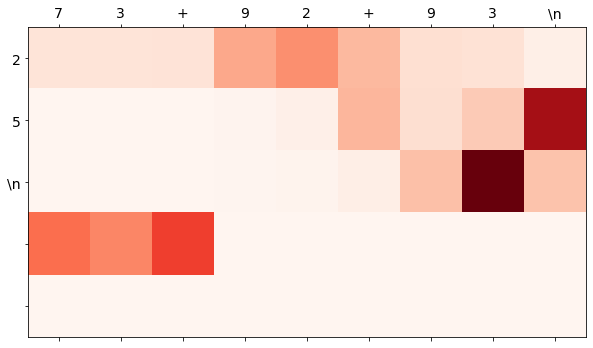

input = 4+38+7, result = 50, actual = 49


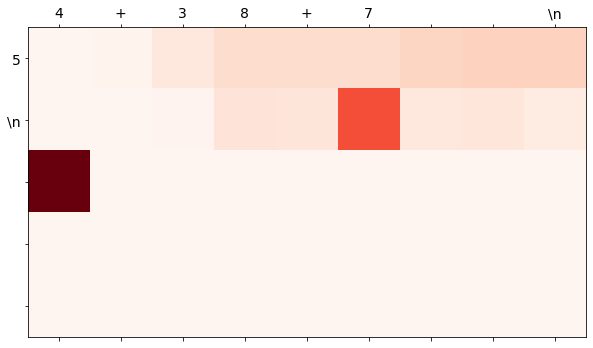

input = 54+76+79, result = 210, actual = 209


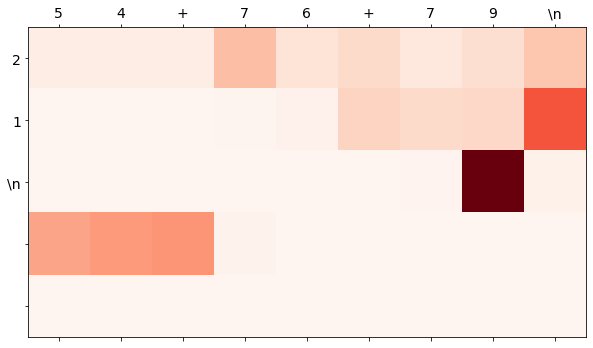

input = 8+50+8, result = 67, actual = 66


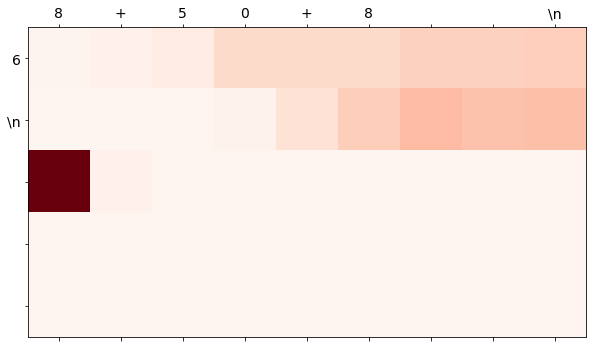

input = 92+97+12, result = 202, actual = 201


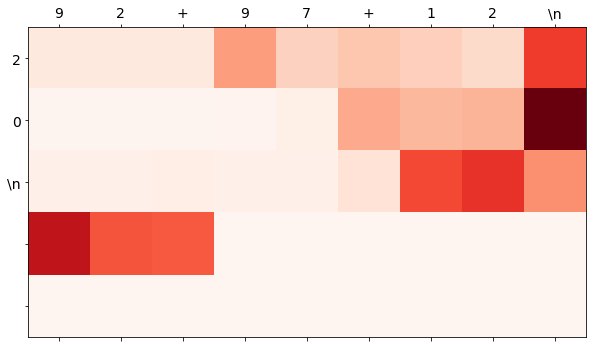

input = 75+7+9, result = 90, actual = 91


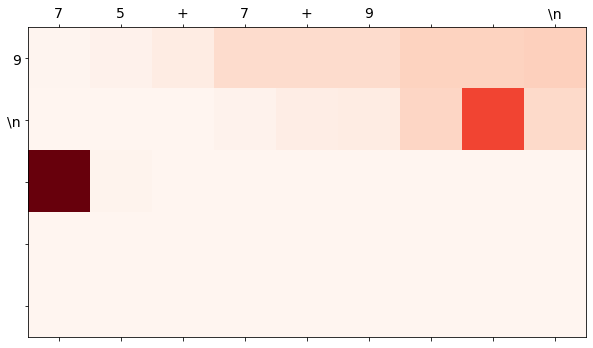

input = 10+11+80, result = 102, actual = 101


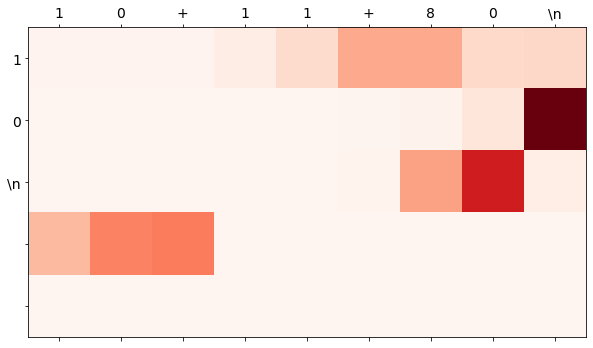

input = 64+77+47, result = 189, actual = 188


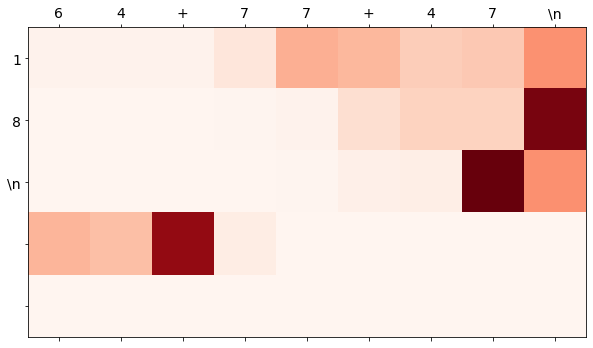

input = 74+84+93, result = 252, actual = 251


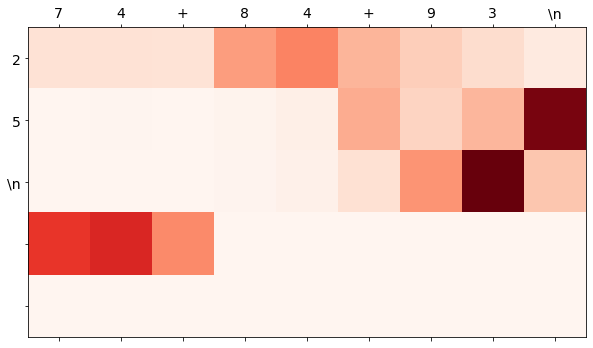

input = 16+77+64, result = 158, actual = 157


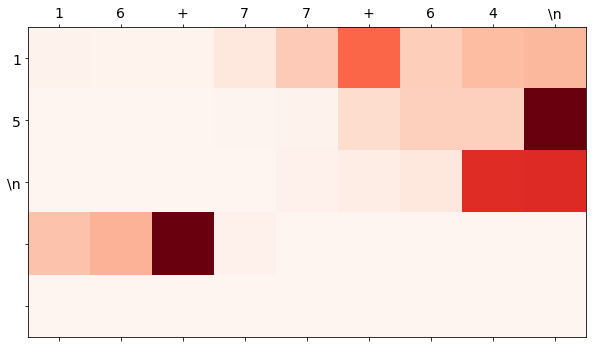

input = 74+85+75, result = 235, actual = 234


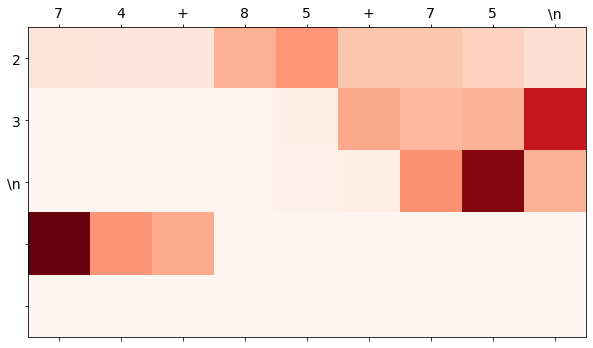

In [128]:
for k, attention_plot in incorrect_attn_plots.items():
    sentence, result, actual = k
    print(f'input = {sentence.strip()}, result = {result}, actual = {actual}')
    plot_attention(attention_plot, sentence, result)
    print('='*100)

Input: 0+12
 
Predicted translation: 12



<ipython-input-25-c1de69a79c6e>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, fontdict=fontdict)
<ipython-input-25-c1de69a79c6e>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks, fontdict=fontdict)


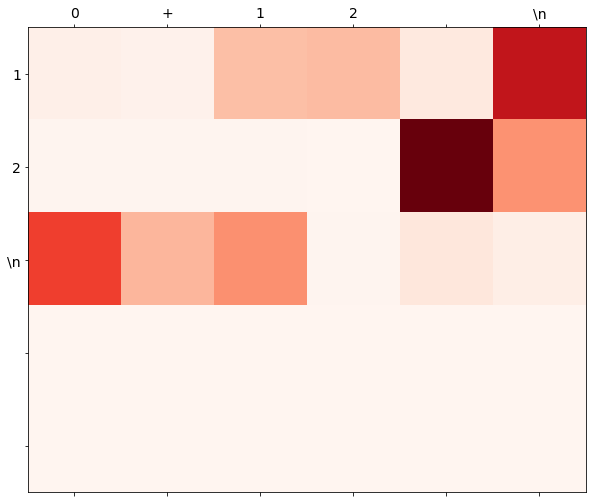

In [32]:
generate_example_plot(input='0+12\n ')a